In [ ]:
! pip3 install --upgrade --user --quiet google-cloud-aiplatform

In [ ]:
import sys
import re
import pandas as pd
import matplotlib.pyplot as plt

# if "google.colab" in sys.modules:
#     import IPython

#     app = IPython.Application.instance()
#     app.kernel.do_shutdown(True)

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

In [ ]:
PROJECT_ID = "aims-ai2324-std-isaacto-vyv"
LOCATION = "us-central1"

import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

In [ ]:
from vertexai.generative_models import GenerationConfig, GenerativeModel

In [ ]:
model = GenerativeModel("gemini-1.5-pro")

In [ ]:
generation_config = GenerationConfig(
    temperature=0.9,
    top_p=1.0,
    top_k=32,
    candidate_count=1,
    max_output_tokens=8192,
)

In [ ]:
chat = model.start_chat(response_validation=False)

# safe = [
#     {
#         "category": "HARM_CATEGORY_DANGEROUS",
#         "threshold": "BLOCK_NONE",
#     },
#     {
#         "category": "HARM_CATEGORY_HARASSMENT",
#         "threshold": "BLOCK_NONE",
#     },
#     {
#         "category": "HARM_CATEGORY_HATE_SPEECH",
#         "threshold": "BLOCK_NONE",
#     },
#     {
#         "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
#         "threshold": "BLOCK_NONE",
#     },
#     {
#         "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
#         "threshold": "BLOCK_NONE",
#     }
# ]

def grade_story(story):
    prompt = f"""Grade the story out of 40 based on:
1. Grammar (10)
2. Coherence (10)
3. Plot (10)
4. Creativity (10)

Provide short comments (1-2 sentences) for each category in the format:
- Grammar: [score], [comment]
- Coherence: [score], [comment]
- Plot: [score], [comment]
- Creativity: [score], [comment]
Overall Score: [score]

Story:\n\n{story.strip()}\n\n"""

    responses = chat.send_message(prompt, stream=True)

    score = ''
    for response in responses:
        score += response.text

    return score.strip()

In [120]:
def samp_story(textfile):

  with open(textfile, 'r', encoding='utf-8', errors='ignore') as file:
    stories = file.read().split('\n')

  min_word_count = 50
  sampled_stories = []

  for i, story in enumerate(stories):
    word_count = len(story.split())

    if story.strip() and word_count >= min_word_count:
        sampled_stories.append((story))

    if len(sampled_stories) >= 350:
        break

  return sampled_stories

In [ ]:
def grading(stories):
  grades = []
  count = 0

  for i, story in enumerate(stories):
    if story.strip():
      try:
        grade = grade_story(story)
        grades.append((i+1, grade))
        count += 1

        if count>= 200:
          break
      except Exception as e:
        continue

  return grades

In [ ]:
# def extract_scores(grading_results):
#     extracted_scores = []

#     for _, result in grading_results:
#         # Use regex to match each score
#         grammar_match = re.search(r'\*\*Grammar:\*\*\s*(\d+)/10', result)
#         coherence_match = re.search(r'\*\*Coherence:\*\*\s*(\d+)/10', result)
#         plot_match = re.search(r'\*\*Plot:\*\*\s*(\d+)/10', result)
#         creativity_match = re.search(r'\*\*Creativity:\*\*\s*(\d+)/10', result)
#         overall_match = re.search(r'\*\*Overall Score:\s*(\d+)/40', result)

#         if all([grammar_match, coherence_match, plot_match, creativity_match, overall_match]):
#             scores = {
#                 'Grammar': int(grammar_match.group(1)),
#                 'Coherence': int(coherence_match.group(1)),
#                 'Plot': int(plot_match.group(1)),
#                 'Creativity': int(creativity_match.group(1)),
#                 'Overall': int(overall_match.group(1))
#             }
#             extracted_scores.append(scores)
#         else:
#             print(f"Failed to match scores for the following result: {result[:100]}...")

#     return extracted_scores

In [ ]:
def extract(grades):
    extracted_scores = []

    grammar_pattern = r"Grammar.*?(\d{1,2})/10"
    coherence_pattern = r"Coherence.*?(\d{1,2})/10"
    plot_pattern = r"Plot.*?(\d{1,2})/10"
    creativity_pattern = r"Creativity.*?(\d{1,2})/10"
    overall_pattern = r"Overall Score.*?(\d{1,2})/40"

    for grade in grades:
        grade_text = grade[1]

        scores = {
            'Grammar': None,
            'Coherence': None,
            'Plot': None,
            'Creativity': None,
            'Overall': None
        }

        grammar_match = re.search(grammar_pattern, grade_text)
        coherence_match = re.search(coherence_pattern, grade_text)
        plot_match = re.search(plot_pattern, grade_text)
        creativity_match = re.search(creativity_pattern, grade_text)
        overall_match = re.search(overall_pattern, grade_text)

        if grammar_match:
            scores['Grammar'] = int(grammar_match.group(1))
        if coherence_match:
            scores['Coherence'] = int(coherence_match.group(1))
        if plot_match:
            scores['Plot'] = int(plot_match.group(1))
        if creativity_match:
            scores['Creativity'] = int(creativity_match.group(1))
        if overall_match:
            scores['Overall'] = int(overall_match.group(1))

        if any(scores.values()):
            extracted_scores.append(scores)
        else:
            print(f"Failed to match scores for the following result: {grade_text[:100]}...")

    return extracted_scores

In [ ]:
def plot_function(dataframe, name):
  categories = ['Grammar', 'Coherence', 'Plot', 'Creativity']
  plt.figure(figsize=(15, 10))

  plt.suptitle(f'Scores Distribution for {name}', fontsize=16)

  for i, category in enumerate(categories, start=1):
      plt.subplot(2, 2, i)
      plt.hist(ZMax_df[category], bins=range(0, 11), alpha=0.7, edgecolor='black')
      plt.title(f'Distribution of Scores for {category} Category')
      plt.xlabel('Scores')
      plt.ylabel('Number of Stories')
      plt.xticks(range(11))
      # plt.grid(axis='y', alpha=0.75)

  plt.tight_layout()
  plt.savefig(f'{name}.pdf', bbox_inches='tight')
  plt.show()

##Scoring ZMax Stories##

In [ ]:
ZMax = samp_story('eval_ZuluMax.txt')
ZMax_grades = grading(ZMax)
ZMax_scores = extract(ZMax_grades)
ZMax_df = pd.DataFrame(ZMax_scores)

In [ ]:
ZMax_df.head()

,Grammar,Coherence,Plot,Creativity,Overall
0,8,9,6,6,29
1,9,8,5,5,27
2,9,9,7,7,32
3,9,10,8,8,35
4,8,9,6,6,29


##Visualizing ZMax Scores##

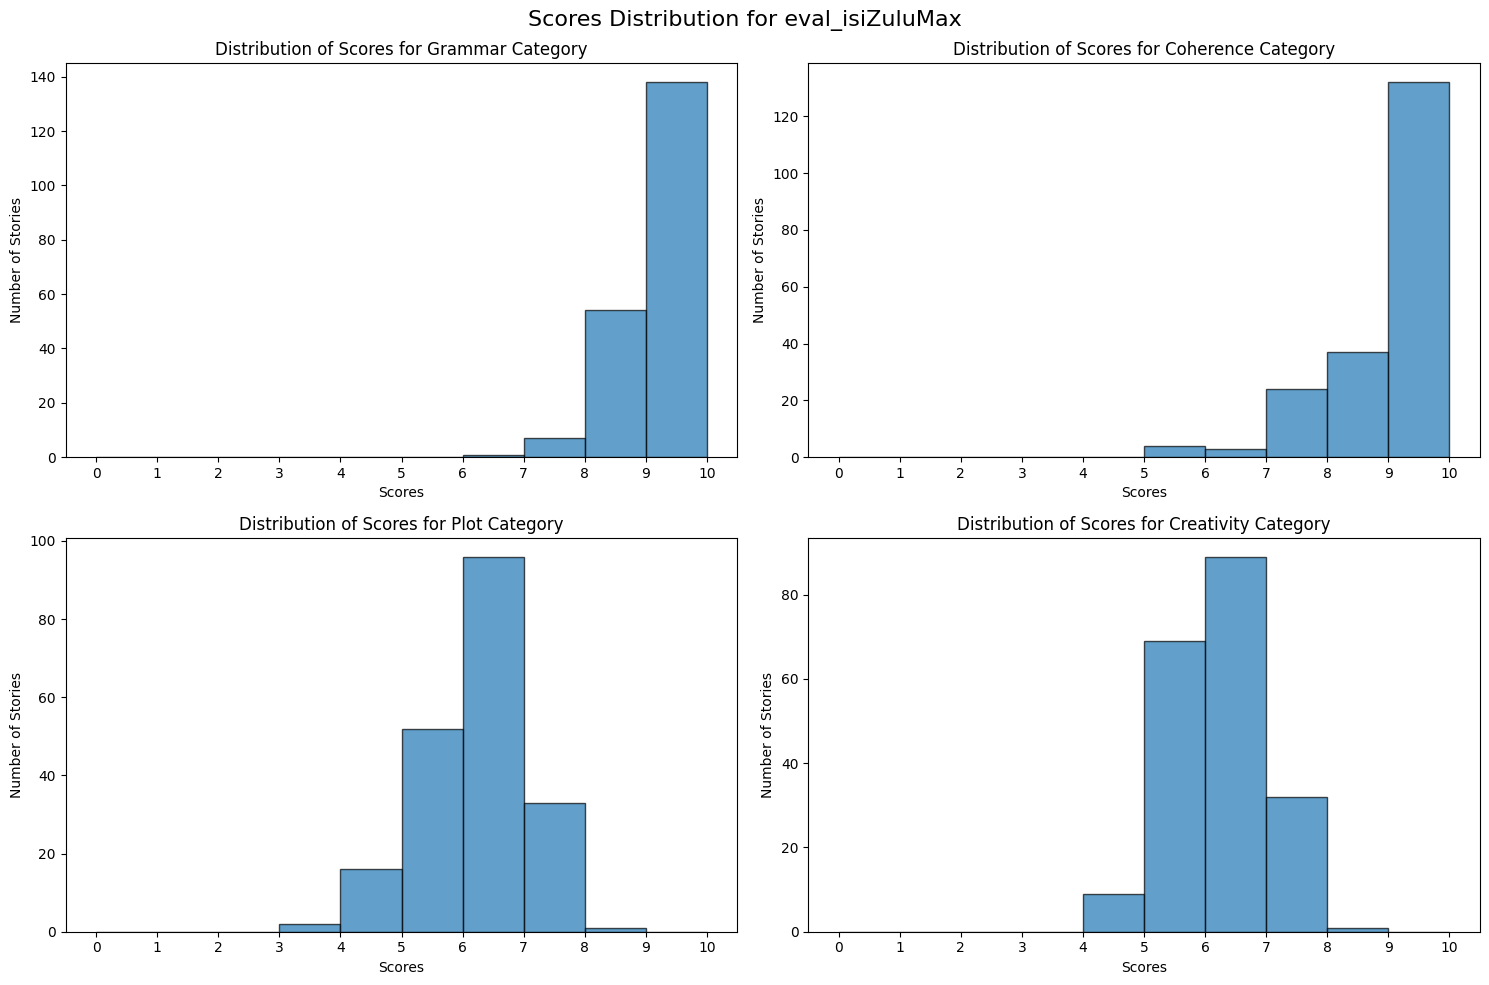

In [ ]:
plot_function(ZMax_df, 'eval_isiZuluMax')

In [ ]:
average_scores = ZMax_df[['Grammar', 'Coherence', 'Plot', 'Creativity']].mean()
normalized_average_scores = average_scores / 10
ZMax_dfnew = pd.DataFrame({
    'Average Score': average_scores,
    'Normalized Average Score': normalized_average_scores
})

In [ ]:
ZMax_dfnew

,Average Score,Normalized Average Score
Grammar,8.650,0.8650
Coherence,8.650,0.8650
Plot,5.725,0.5725
Creativity,5.735,0.5735


##Scoring ZMin Stories##

In [ ]:
ZMin = samp_story('eval_ZuluMini.txt')
ZMin_grades = grading(ZMin)

ZMin_scores = extract(ZMin_grades)
ZMin_df = pd.DataFrame(ZMin_scores)

In [ ]:
ZMin_df.head()

,Grammar,Coherence,Plot,Creativity,Overall
0,9,10,5,6,30
1,9,10,7,6,32
2,9,9,6,6,30
3,9,9,6,6,30
4,7,6,5,5,23


##Visualising ZMin Scores##

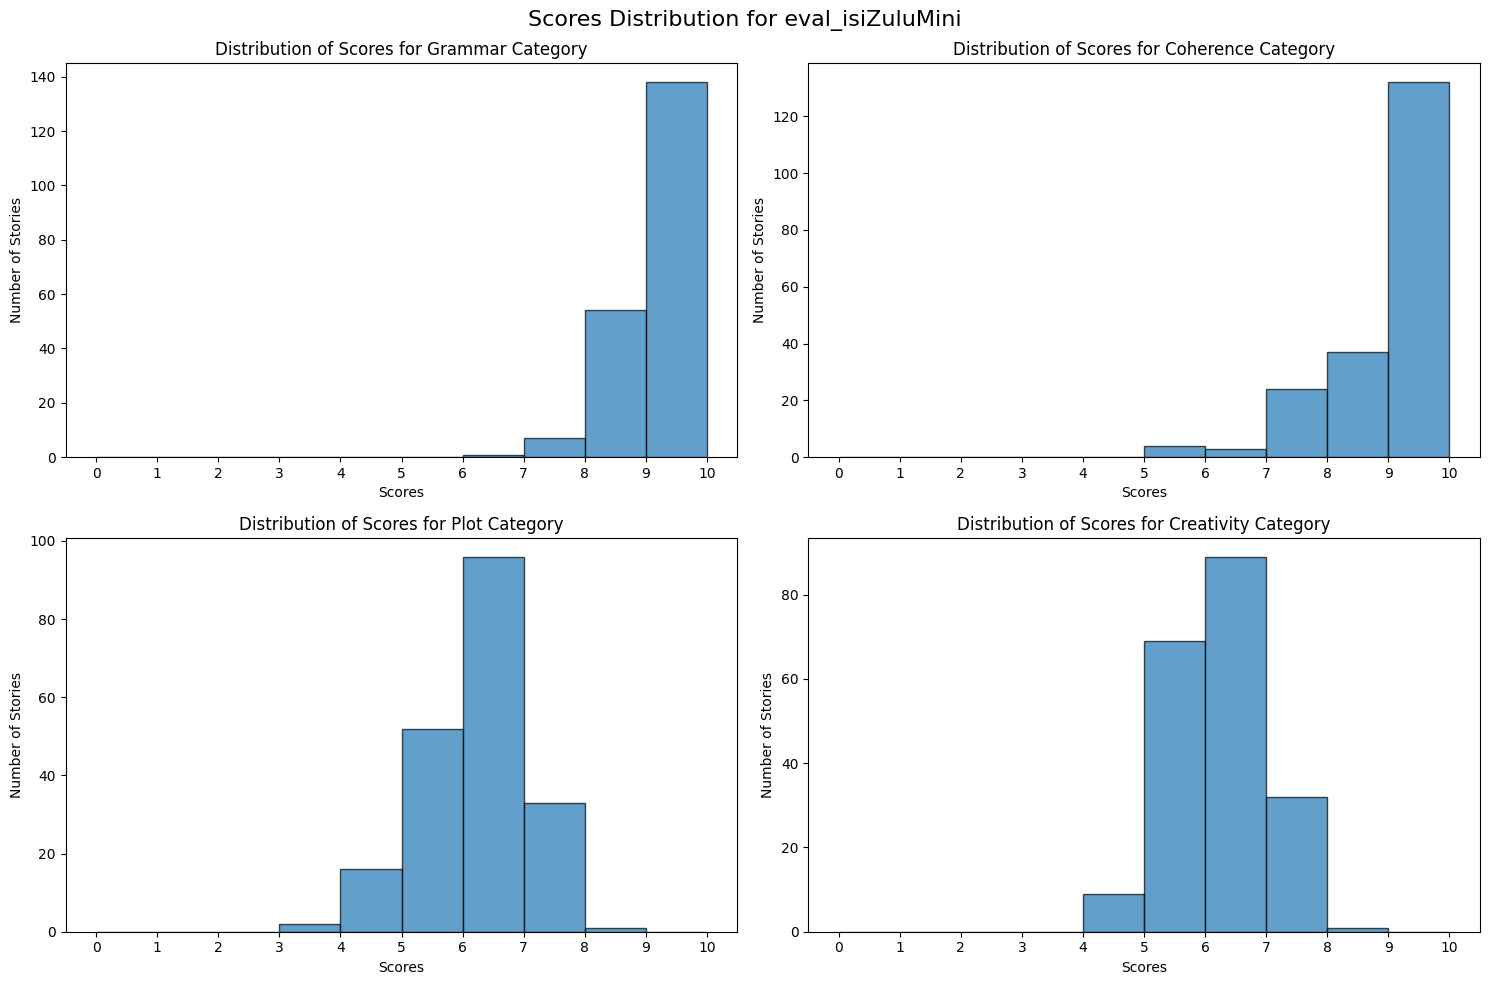

In [108]:
plot_function(ZMin_df, 'eval_isiZuluMini')

In [109]:
average_scores = ZMin_df[['Grammar', 'Coherence', 'Plot', 'Creativity']].mean()
normalized_average_scores = average_scores / 10
ZMin_dfnew = pd.DataFrame({
    'Average Score': average_scores,
    'Normalized Average Score': normalized_average_scores
})

In [110]:
ZMin_dfnew

,Average Score,Normalized Average Score
Grammar,8.635,0.8635
Coherence,8.885,0.8885
Plot,5.815,0.5815
Creativity,5.775,0.5775


##Scoring ZPrompt Stories##

In [111]:
ZPrompt = samp_story('eval_ZuluPrompt.txt')
ZPrompt_grades = grading(ZPrompt)
ZPrompt_scores = extract(ZPrompt_grades)
ZPrompt_df = pd.DataFrame(ZPrompt_scores)

In [114]:
ZPrompt_df.head()

,Grammar,Coherence,Plot,Creativity,Overall
0,9,10,5,6,30
1,9,7,4,5,25
2,8,9,7,6,30
3,9,10,6,7,32
4,7,8,6,7,28


##Visualising ZPrompt Scores##

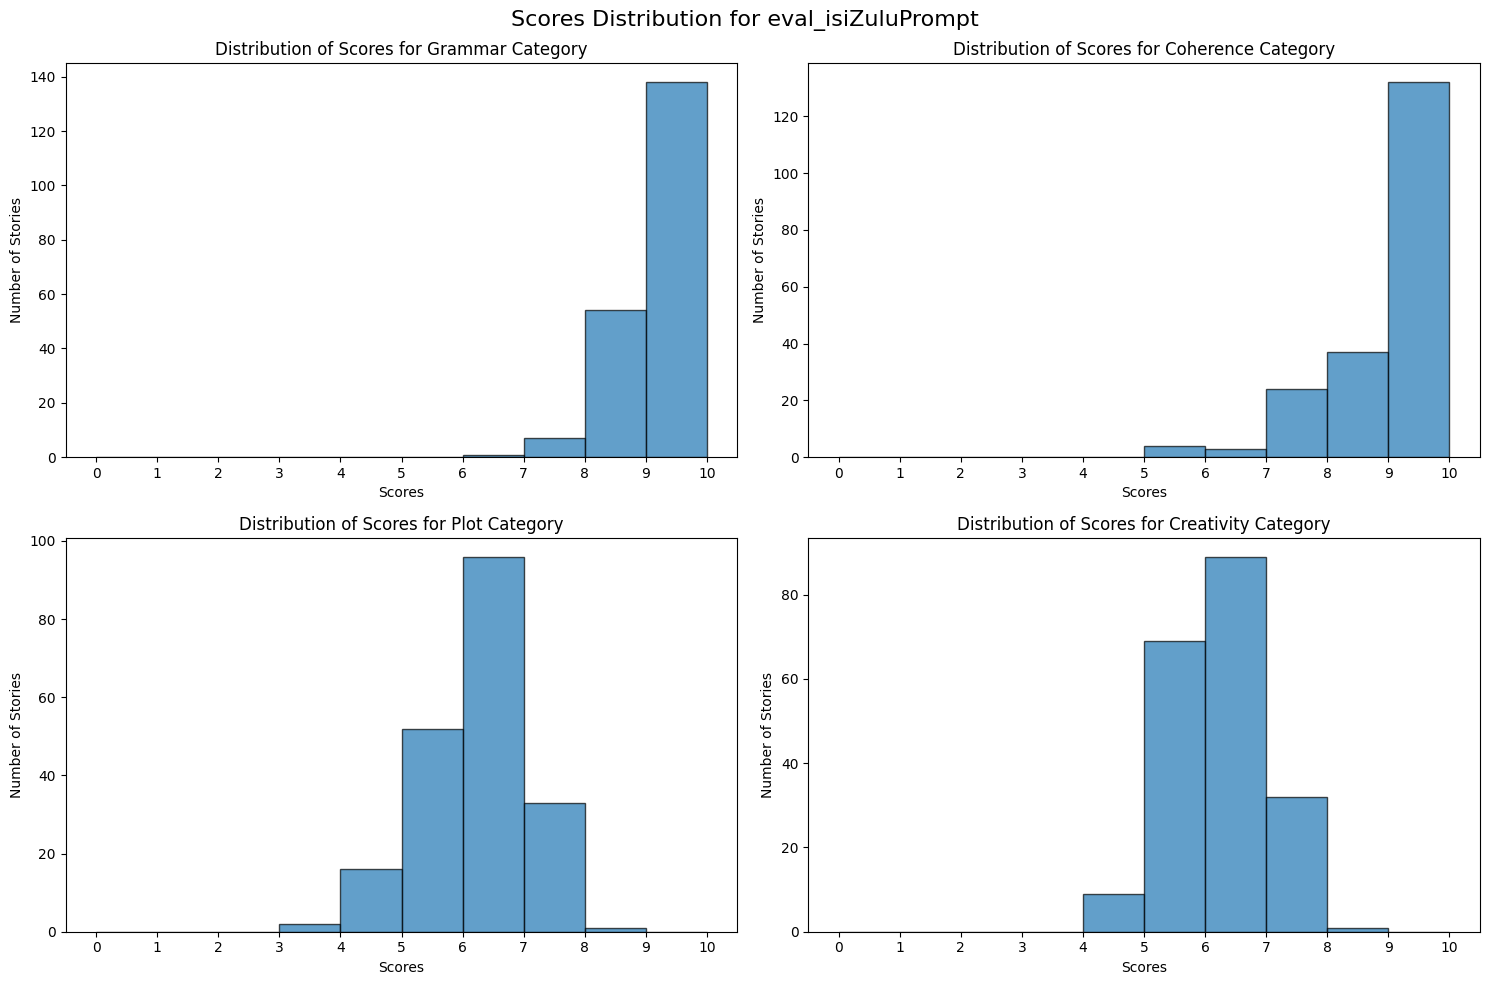

In [115]:
plot_function(ZPrompt_df, 'eval_isiZuluPrompt')

In [116]:
average_scores = ZPrompt_df[['Grammar', 'Coherence', 'Plot', 'Creativity']].mean()
normalized_average_scores = average_scores / 10
ZPrompt_dfnew = pd.DataFrame({
    'Average Score': average_scores,
    'Normalized Average Score': normalized_average_scores
})

In [117]:
ZPrompt_dfnew

,Average Score,Normalized Average Score
Grammar,8.545,0.8545
Coherence,8.295,0.8295
Plot,5.365,0.5365
Creativity,5.780,0.5780


##Scoring YMax Stories##

In [121]:
YMax = samp_story('eval_YorubaMax.txt')
YMax_grades = grading(YMax)
YMax_scores = extract(YMax_grades)
YMax_df = pd.DataFrame(YMax_scores)

In [123]:
YMax_df.head()

,Grammar,Coherence,Plot,Creativity,Overall
0,8,9,6,7,30
1,7,8,6,5,26
2,8,9,5,6,28
3,9,10,5,5,29
4,8,9,5,5,27


##Visualising YMax Scores##

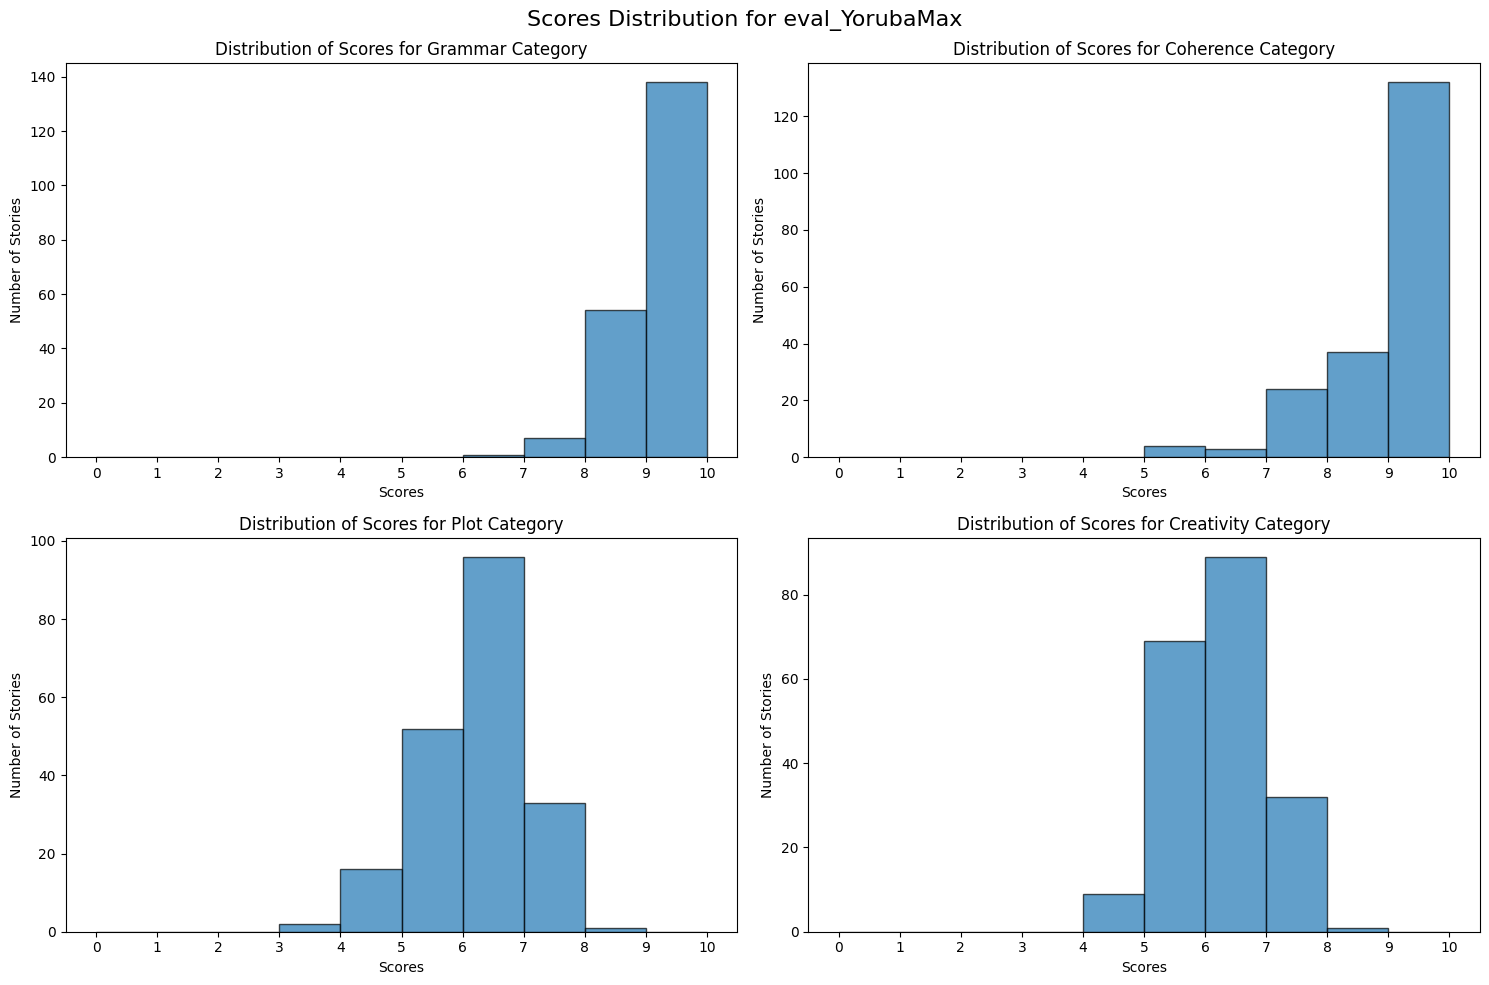

In [124]:
plot_function(YMax_df, 'eval_YorubaMax')

In [125]:
average_scores = YMax_df[['Grammar', 'Coherence', 'Plot', 'Creativity']].mean()
normalized_average_scores = average_scores / 10
YMax_dfnew = pd.DataFrame({
    'Average Score': average_scores,
    'Normalized Average Score': normalized_average_scores
})

In [126]:
YMax_dfnew

,Average Score,Normalized Average Score
Grammar,8.205,0.8205
Coherence,8.880,0.8880
Plot,5.675,0.5675
Creativity,5.620,0.5620


##Scoring YMini Stories##


In [127]:
YMini = samp_story('eval_YorubaMini.txt')
YMini_grades = grading(YMini)
YMini_scores = extract(YMini_grades)
YMini_df = pd.DataFrame(YMini_scores)

In [128]:
len(YMini_df)

200

In [129]:
YMini_df.head()

,Grammar,Coherence,Plot,Creativity,Overall
0,8,9,7,7,31
1,9,7,5,6,27
2,8,9,5,5,27
3,9,10,6,6,31
4,9,10,7,6,32


##Visualising YMini Scores##

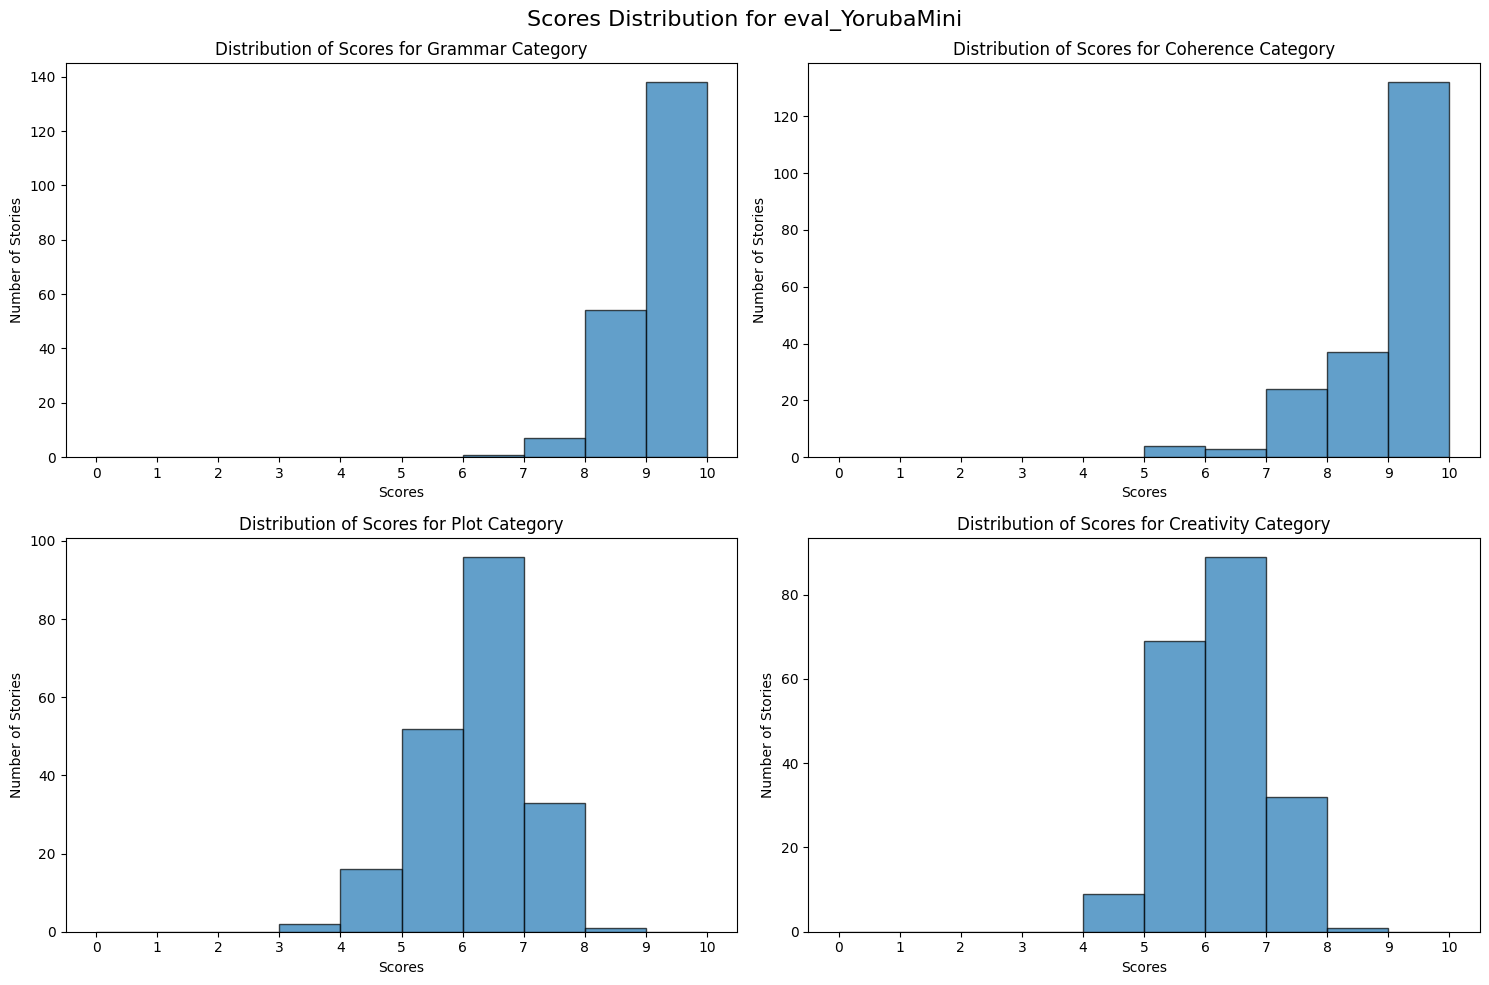

In [130]:
plot_function(YMini_df, 'eval_YorubaMini')

In [131]:
average_scores = YMini_df[['Grammar', 'Coherence', 'Plot', 'Creativity']].mean()
normalized_average_scores = average_scores / 10
YMini_dfnew = pd.DataFrame({
    'Average Score': average_scores,
    'Normalized Average Score': normalized_average_scores
})

In [132]:
YMini_dfnew

,Average Score,Normalized Average Score
Grammar,8.340,0.8340
Coherence,8.655,0.8655
Plot,5.675,0.5675
Creativity,5.545,0.5545


##Scoring YPrompt Stories##

In [133]:
YPrompt = samp_story('eval_YorubaPrompt.txt')
YPrompt_grades = grading(YPrompt)
YPrompt_scores = extract(YPrompt_grades)
YPrompt_df = pd.DataFrame(YPrompt_scores)

In [134]:
len(YPrompt_df)

200

In [135]:
YPrompt_df.head()

,Grammar,Coherence,Plot,Creativity,Overall
0,7,6,4,5,22
1,7,8,5,6,26
2,8,7,5,5,25
3,8,7,5,5,25
4,9,10,6,6,31


##Visualizing YPrompt Scores##

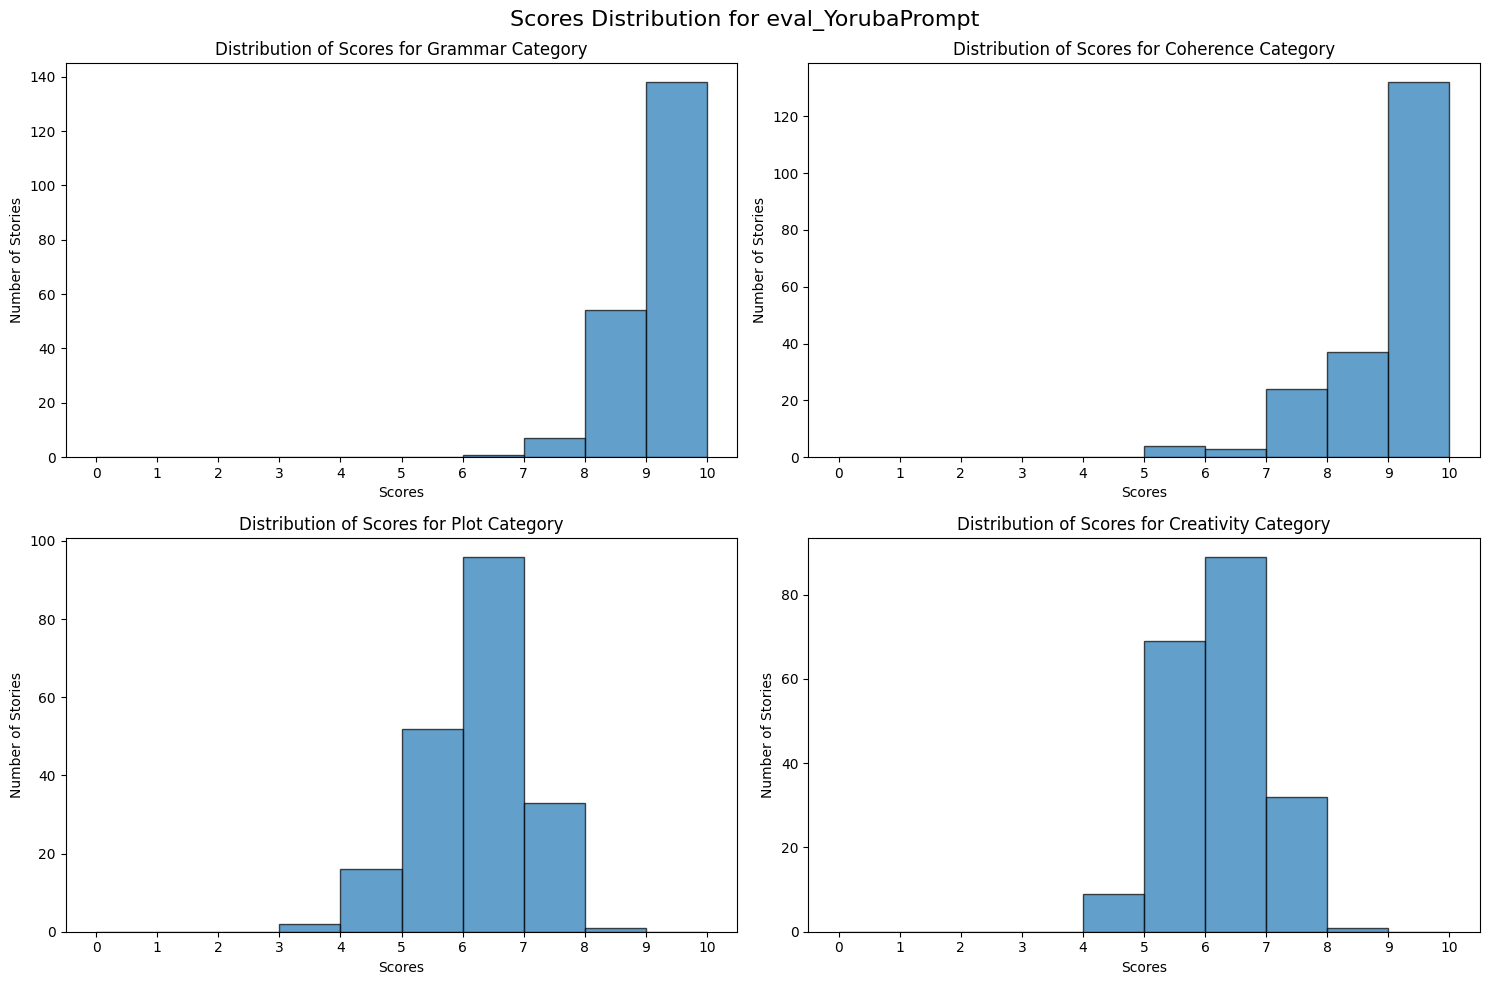

In [136]:
plot_function(YPrompt_df, 'eval_YorubaPrompt')

In [137]:
average_scores = YPrompt_df[['Grammar', 'Coherence', 'Plot', 'Creativity']].mean()
normalized_average_scores = average_scores / 10
YPrompt_dfnew = pd.DataFrame({
    'Average Score': average_scores,
    'Normalized Average Score': normalized_average_scores
})

In [138]:
YPrompt_dfnew

,Average Score,Normalized Average Score
Grammar,8.270,0.8270
Coherence,8.065,0.8065
Plot,5.160,0.5160
Creativity,5.535,0.5535
